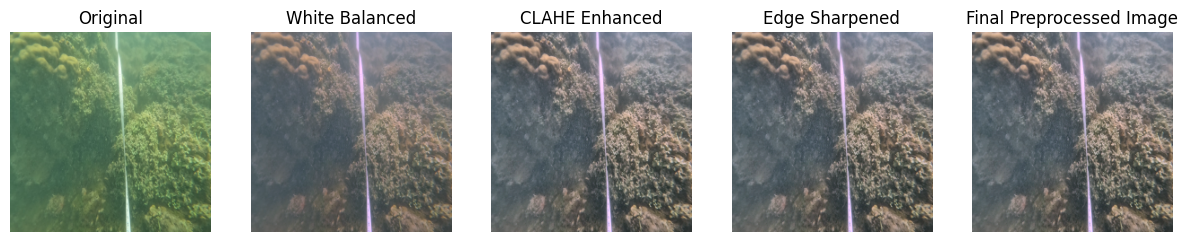

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

class UnderwaterImagePreprocessor:
    def __init__(self, brightness_threshold=100, sharpness_intensity=0.1, brightness_adjustment_level=1.05):
        self.brightness_threshold = brightness_threshold
        self.sharpness_intensity = sharpness_intensity  # Subtle sharpness intensity
        self.brightness_adjustment_level = brightness_adjustment_level

    def needs_brightness_increase(self, image):
        """ Determines if brightness needs adjustment by analyzing the histogram. """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dark_pixels = np.sum(gray < 50)
        total_pixels = gray.size
        dark_pixel_ratio = dark_pixels / total_pixels
        return dark_pixel_ratio > 0.2

    def white_balance_needed(self, image):
        """ Check if white balance is needed by comparing the color channels' averages. """
        b, g, r = cv2.split(image)
        avg_b, avg_g, avg_r = np.mean(b), np.mean(g), np.mean(r)
        return not (abs(avg_b - avg_g) < 5 and abs(avg_g - avg_r) < 5)

    def clahe_needed(self, image):
        """ Check if contrast enhancement is needed by measuring standard deviation. """
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, _, _ = cv2.split(lab)
        return np.std(l) < 60

    def white_balance(self, image):
        """ Adjusts white balance with controlled scaling to reduce excessive brightness. """
        b, g, r = cv2.split(image)
        avg_b, avg_g, avg_r = np.mean(b), np.mean(g), np.mean(r)
        avg = (avg_b + avg_g + avg_r) / 3
        b = np.clip(b * (avg / (avg_b + 1e-5)), 0, 255)
        g = np.clip(g * (avg / (avg_g + 1e-5)), 0, 255)
        r = np.clip(r * (avg / (avg_r + 1e-5)), 0, 255)
        return cv2.merge((b.astype(np.uint8), g.astype(np.uint8), r.astype(np.uint8)))

    def clahe_enhancement(self, image):
        """ Enhances contrast using CLAHE with more subtle settings. """
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))  # More subtle enhancement
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    def brightness_adjustment(self, image):
        """ Adjusts brightness more conservatively based on histogram analysis. """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_brightness = np.mean(gray)
        if mean_brightness < self.brightness_threshold:
            alpha = self.brightness_adjustment_level
        else:
            alpha = 1.0  # No adjustment if already bright enough
        return cv2.convertScaleAbs(image, alpha=alpha, beta=10)

    def edge_sharpening(self, image):
        """ Subtly sharpens edges to enhance image details without over-sharpening. """
        sharpening_kernel = np.array([[0, -0.05, 0], [-0.05, 1.05, -0.05], [0, -0.05, 0]])  # Reduced sharpness
        sharpened = cv2.filter2D(image, -1, sharpening_kernel)
        return cv2.addWeighted(image, 1 - self.sharpness_intensity, sharpened, self.sharpness_intensity, 0)

    def preprocess(self, image):
        """ Preprocessing pipeline with conditional application of each technique. """
        steps_applied = []

        # Step 1: White balance adjustment
        if self.white_balance_needed(image):
            image = self.white_balance(image)
            steps_applied.append(("White Balanced", image))

        # Step 2: CLAHE enhancement
        if self.clahe_needed(image):
            image = self.clahe_enhancement(image)
            steps_applied.append(("CLAHE Enhanced", image))

        # Step 3: Brightness adjustment
        if self.needs_brightness_increase(image):
            image = self.brightness_adjustment(image)
            steps_applied.append(("Brightness Adjusted", image))

        # Step 4: Edge sharpening
        image = self.edge_sharpening(image)
        steps_applied.append(("Edge Sharpened", image))

        # Append final preprocessed image
        steps_applied.append(("Final Preprocessed Image", image))

        return steps_applied

    def display_applied_steps(self, original, steps_applied):
        """ Displays each preprocessing step that was conditionally applied. """
        images = [original] + [step[1] for step in steps_applied]
        titles = ["Original"] + [step[0] for step in steps_applied]

        plt.figure(figsize=(15, 8))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(title)
            plt.axis('off')
        plt.show()

# Specify the input image path
input_image_path = 'D:/Annotation of Corals/Preprocessing_dataset/0001.png'  # Replace with your image path

# Specify the output folder
output_folder = 'D:/Annotation of Corals/Preprocessing_dataset'  # Output folder for saving preprocessed images

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Validate input image path
if not os.path.isfile(input_image_path):
    raise FileNotFoundError(f"Input image not found: {input_image_path}")

# Initialize the preprocessor
preprocessor = UnderwaterImagePreprocessor(sharpness_intensity=0.05)  # Subtle sharpness

# Read the input image
original_image = cv2.imread(input_image_path)

# Apply each preprocessing step conditionally
steps_applied = preprocessor.preprocess(original_image)

# Get the output image path, ensuring the extension is ".jpg"
output_image_path = os.path.join(output_folder, "preprocessed_image.jpg")

# Save the final preprocessed image as a JPG, regardless of input format
cv2.imwrite(output_image_path, steps_applied[-1][1])  # Save the last processed image (final)

# Optionally, display the steps applied
preprocessor.display_applied_steps(original_image, steps_applied)